In [24]:
import random
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torch.utils.data import DataLoader

In [5]:
train_set = MNIST('~/datasets/mnist', train=True, download=True)
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/isadrtdinov/datasets/mnist
    Split: Train

In [6]:
len(train_set)

60000

In [7]:
i = random.randint(0, len(train_set) - 1)
out = train_set[i]
out

(<PIL.Image.Image image mode=L size=28x28>, 8)

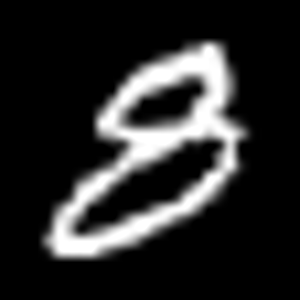

In [9]:
out[0].resize((300, 300))

In [15]:
to_tensor = T.ToTensor()
train_set = MNIST('~/datasets/mnist', train=True, download=True, transform=to_tensor)
test_set = MNIST('~/datasets/mnist', train=False, download=True, transform=to_tensor)

In [16]:
i = random.randint(0, len(train_set) - 1)
out = train_set[i]

In [18]:
out[0].shape

torch.Size([1, 28, 28])

In [20]:
train_loader = DataLoader(train_set, batch_size=64, pin_memory=True, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, pin_memory=True, shuffle=False, num_workers=4)

In [21]:
for images, labels in train_loader:
    break

In [23]:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [30]:
nn.ModuleList?

In [33]:
class Net(nn.Module):
    def __init__(self, num_hidden=32, num_classes=10):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28 * 28, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_classes)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [54]:
net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net

Net(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [55]:
for param in net.parameters():
    print(param.shape, param.requires_grad)

torch.Size([32, 784]) True
torch.Size([32]) True
torch.Size([10, 32]) True
torch.Size([10]) True


In [56]:
sum(param.numel() for param in net.parameters())

25450

In [57]:
32 * 784 + 32 + 10 * 32 + 10

25450

In [58]:
x = torch.randn(512, 784)
y = net(x)  # equivalent to net.forward(x)
assert y.shape == (512, 10)

In [60]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    net.train()
    train_loss, train_accuracy = 0.0, 0.0
    for images, labels in train_loader:
        # images: (B, 1, 28, 28), labels: (B, )
        images = images.to(device)
        labels = labels.to(device)
        images = torch.flatten(images, start_dim=1)
        # images: (B, 784)

        optimizer.zero_grad()  # alternatively net.zero_grad()
        logits = net(images)
        # logits: (B, 10)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=-1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)

    net.eval()
    test_loss, test_accuracy = 0.0, 0.0
    for images, labels in test_loader:
        # images: (B, 1, 28, 28), labels: (B, )
        images = images.to(device)
        labels = labels.to(device)
        images = torch.flatten(images, start_dim=1)
        # images: (B, 784)

        with torch.inference_mode():  # torch.no_grad()
            logits = net(images)
            # logits: (B, 10)
            loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=-1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)

    print(
        f'Epoch #{epoch}: train loss = {train_loss:.3f}, train accuracy = {train_accuracy * 100:.2f}%, '
        f'test loss = {test_loss:.3f}, test accuracy = {test_accuracy * 100:.2f}%'
    )

Epoch #1: train loss = 0.488, train accuracy = 86.48%, test loss = 0.273, test accuracy = 92.23%
Epoch #2: train loss = 0.254, train accuracy = 92.69%, test loss = 0.222, test accuracy = 93.57%
Epoch #3: train loss = 0.209, train accuracy = 94.01%, test loss = 0.183, test accuracy = 94.64%
Epoch #4: train loss = 0.179, train accuracy = 94.80%, test loss = 0.164, test accuracy = 95.24%
Epoch #5: train loss = 0.158, train accuracy = 95.45%, test loss = 0.150, test accuracy = 95.48%
Epoch #6: train loss = 0.142, train accuracy = 95.83%, test loss = 0.141, test accuracy = 95.77%
Epoch #7: train loss = 0.130, train accuracy = 96.24%, test loss = 0.139, test accuracy = 95.89%
Epoch #8: train loss = 0.121, train accuracy = 96.42%, test loss = 0.127, test accuracy = 96.01%
Epoch #9: train loss = 0.112, train accuracy = 96.70%, test loss = 0.124, test accuracy = 96.24%
Epoch #10: train loss = 0.105, train accuracy = 96.91%, test loss = 0.115, test accuracy = 96.32%
